<a href="https://colab.research.google.com/github/songguan26/Deep-learning-models-to-automatically-classify-medically-important-mosquitoes-in-North-Borneo/blob/main/mobilenetV2_North_Borneo_mosquito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from collections import Counter

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD
from keras import Model, layers
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

In [ ]:
!nvidia-smi

Sat Jun 24 10:54:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
root_path = 'path to images'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = 'train'
seg_test_folders = 'test'
seg_pred_folders = 'pred'

In [ ]:
def do_history_stuff(history, history_file_name, ismobilenet=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, ismobilenet)
    plot_loss_from_history(history)

def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:
    hist_df = pd.DataFrame(history.history)

    # save to json:
    hist_json_file = model_name+'_history.json'
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv:
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

def plot_accuracy_from_history(history, ismobilenet=False):
    color = sns.color_palette()
    if(ismobilenet == False):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']


    epochs = range(len(acc))

    sns.lineplot(x=epochs, y=acc, label='Training Accuracy')
    sns.lineplot(x=epochs, y=val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()

def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    sns.lineplot(x=epochs, y=loss,label='Training Loss')
    sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()

In [ ]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.0)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance.
train_generator = train_datagen.flow_from_directory(seg_train_folders,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(seg_test_folders, shuffle=True, batch_size=32, class_mode='categorical', target_size=(224, 224))

test_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_generator = test_datagen.flow_from_directory(seg_pred_folders, shuffle=True, batch_size=32, class_mode='categorical', target_size=(224, 224))

Found 392 images belonging to 2 classes.
Found 104 images belonging to 2 classes.
Found 96 images belonging to 2 classes.


In [ ]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'red_flour_beetle': 0, 'rice_weevil': 1}
{0: 'red_flour_beetle', 1: 'rice_weevil'}


Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 1.1864 - accuracy: 0.6327
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to MobileNetV2-saved-model-01-loss-1.19.hdf5
13/13 [==============================] - 9s 453ms/step - loss: 1.1864 - accuracy: 0.6327 - val_loss: 0.2800 - val_accuracy: 0.8750
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.3275 - accuracy: 0.8622
Epoch 2: val_accuracy improved from 0.87500 to 0.95192, saving model to MobileNetV2-saved-model-02-loss-0.33.hdf5
13/13 [==============================] - 5s 380ms/step - loss: 0.3275 - accuracy: 0.8622 - val_loss: 0.1059 - val_accuracy: 0.9519
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.1291 - accuracy: 0.9439
Epoch 3: val_accuracy improved from 0.95192 to 0.97115, saving model to MobileNetV2-saved-model-03-loss-0.13.hdf5
13/13 [==============================] - 5s 395ms/step - loss: 0.1291 - accuracy: 0.9439 - val_loss: 0.0692 - val_

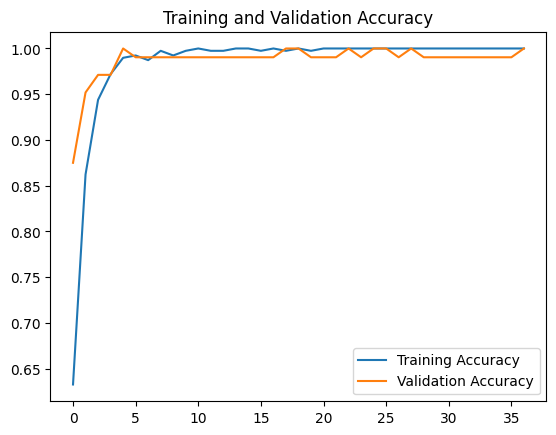

<Figure size 640x480 with 0 Axes>

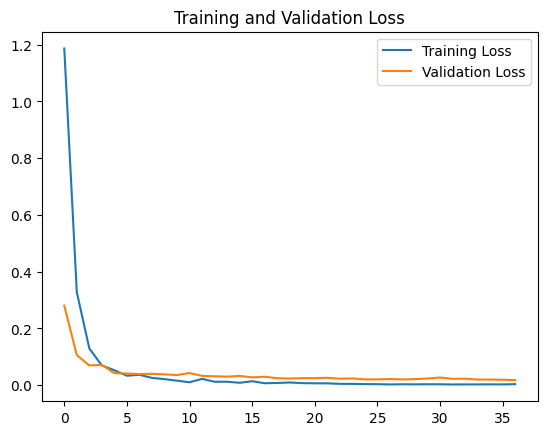

<Figure size 640x480 with 0 Axes>

In [ ]:
#strategy one ->adamlr0.001
#freezing convolutional layers; replacing classification layers
MobileNetV2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layers in MobileNetV2_model.layers:
            layers.trainable=False

last_output = MobileNetV2_model.layers[-1].output
MobileNetV2_x = Flatten()(last_output)
MobileNetV2_x = Dense(128, activation = 'relu')(MobileNetV2_x)
MobileNetV2_x = Dropout(0.3)(MobileNetV2_x)
MobileNetV2_x = Dense(2, activation = 'softmax')(MobileNetV2_x)
MobileNetV2_final_model = Model(MobileNetV2_model.input, MobileNetV2_x)
MobileNetV2_final_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy',metrics=['accuracy'])

# MobileNetV2
MobileNetV2_filepath = 'MobileNetV2'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
MobileNetV2_checkpoint = tf.keras.callbacks.ModelCheckpoint(MobileNetV2_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
MobileNetV2_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
MobileNetV2_history = MobileNetV2_final_model.fit(train_generator, epochs = 100, batch_size=32, validation_data = validation_generator,callbacks=[MobileNetV2_checkpoint,MobileNetV2_early_stopping],verbose=1)

do_history_stuff(MobileNetV2_history, 'MobileNetV2_model')

1/1 [==============================] - 0s 23ms/step
Model Accuracy 0.6458333333333334
                  precision    recall  f1-score   support

red_flour_beetle       0.77      0.42      0.54        48
     rice_weevil       0.60      0.88      0.71        48

        accuracy                           0.65        96
       macro avg       0.68      0.65      0.63        96
    weighted avg       0.68      0.65      0.63        96



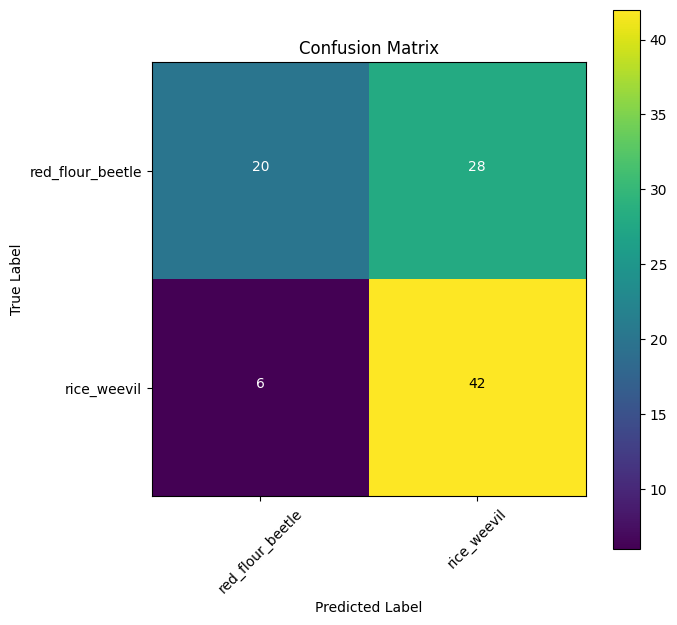

In [ ]:
#prediction

MobileNetV2_best_model = MobileNetV2_final_model

def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
MobileNetV2_pred = []
for folder in os.listdir(seg_pred_folders):

    test_image_ids = os.listdir(os.path.join(seg_pred_folders,folder))

    for image_id in test_image_ids[:int(len(test_image_ids))]:

        path = os.path.join(seg_pred_folders,folder,image_id)

        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(224,224))
        img_normalized = img/255

        #MobileNetV2
        MobileNetV2_image_prediction = np.argmax(MobileNetV2_best_model.predict(np.array([img_normalized])))
        MobileNetV2_pred.append(MobileNetV2_image_prediction)

from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):

    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)

    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

    print(classification_report(true_value, model_pred, target_names = list(classes)))

# MobileNetV2 model classification report
clf_report(true_value, MobileNetV2_pred)